# Evaluation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

project_root = Path.cwd().parent 

def load_processed_data(file_path, is_multi=False):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    if is_multi:
        df['Retrieval Status'] = df['is_hit'].map({True: 'Success', False: 'Fail'})
    else:
        df['Retrieval Status'] = df['hit_rank'].apply(lambda x: 'Success' if x > 0 else 'Fail')
    
    return df
single_path= project_root / "results/rag_eval_full_single_queries_20260112_200932.json" 

multi_path  = project_root / "results/rag_eval_full_multi_turn_20260112_211633.json" 

df_single = load_processed_data(single_path, is_multi=False)
df_multi = load_processed_data(multi_path, is_multi=True)

In [5]:
def generate_summary(df, label):
    total = len(df)
    successes = len(df[df['Retrieval Status'] == 'Success'])
    fails = len(df[df['Retrieval Status'] == 'Fail'])
    hit_rate = (successes / total) * 100
    
    print(f"--- Summary for {label} ---")
    print(f"Total Queries:       {total}")
    print(f"Retrieval Hits:      {successes}")
    print(f"Retrieval Fails:     {fails}")
    print(f"Retrieval Hit Rate:  {hit_rate:.1f}%")
    print(f"Avg. RAG Score:      {df['rag_score'].mean():.2f} / 10.0")
    print(f"Avg. Baseline Score: {df['baseline_score'].mean():.2f} / 10.0\n")

generate_summary(df_single, "Single Turn")
generate_summary(df_multi, "Multi Turn")

--- Summary for Single Turn ---
Total Queries:       747
Retrieval Hits:      693
Retrieval Fails:     54
Retrieval Hit Rate:  92.8%
Avg. RAG Score:      8.27 / 10.0
Avg. Baseline Score: 5.56 / 10.0

--- Summary for Multi Turn ---
Total Queries:       228
Retrieval Hits:      165
Retrieval Fails:     63
Retrieval Hit Rate:  72.4%
Avg. RAG Score:      7.30 / 10.0
Avg. Baseline Score: 6.59 / 10.0



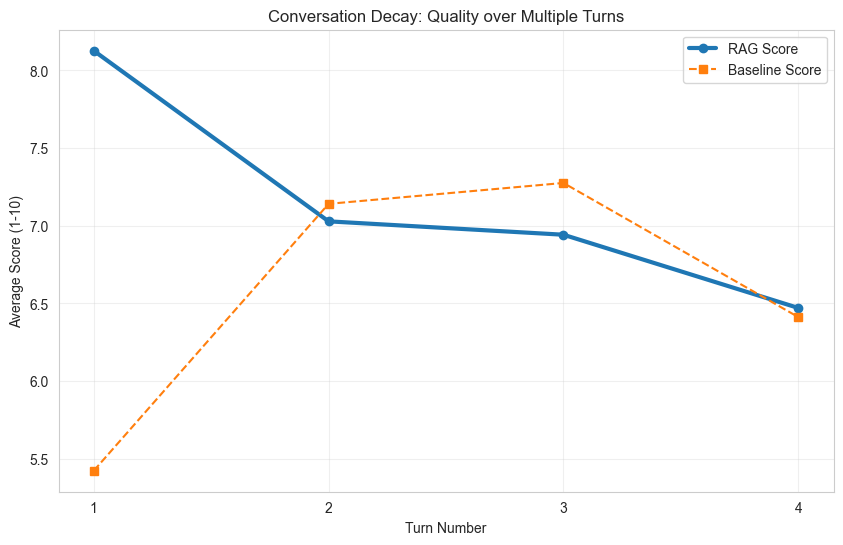

In [6]:
plt.figure(figsize=(10, 6))
decay = df_multi.groupby('turn_number')[['rag_score', 'baseline_score']].mean().reset_index()

plt.plot(decay['turn_number'], decay['rag_score'], label='RAG Score', marker='o', linewidth=3)
plt.plot(decay['turn_number'], decay['baseline_score'], label='Baseline Score', marker='s', linestyle='--')

plt.title("Conversation Decay: Quality over Multiple Turns")
plt.xlabel("Turn Number")
plt.ylabel("Average Score (1-10)")
plt.xticks(decay['turn_number'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

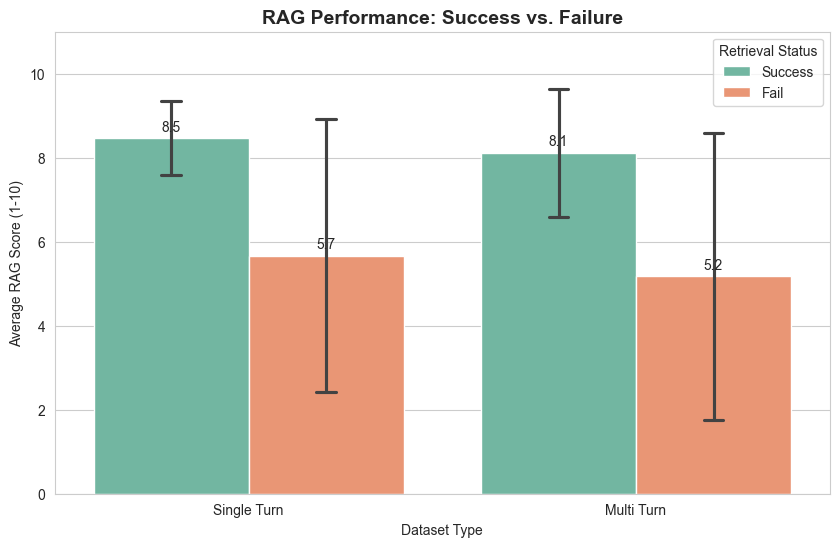

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

combined = pd.concat([
    df_single.assign(Dataset='Single Turn'),
    df_multi.assign(Dataset='Multi Turn')
])
plt.figure(figsize=(10, 6))

sns.barplot(
    data=combined, 
    x='Dataset', 
    y='rag_score', 
    hue='Retrieval Status', 
    palette='Set2',
    capsize=.1,
    errorbar="sd" 
)

plt.title("RAG Performance: Success vs. Failure", fontsize=14, fontweight='bold')
plt.ylabel("Average RAG Score (1-10)")
plt.xlabel("Dataset Type")
plt.ylim(0, 11)
plt.legend(title="Retrieval Status", loc='upper right')

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f', padding=3)

plt.show()